In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Dense, LSTM
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split


In [11]:
# === 1. Load and preprocess data ===
df = pd.read_csv("synthetic_trashcan_fill_levels2.csv")
time_series = df.drop(columns=["edgeID", "trashcanID"])

# Downsample: average every 4 days (200 → 50)
reshaped = time_series.to_numpy().reshape((len(df), 50, 4))
downsampled = reshaped.mean(axis=2)

# Normalize each trash can time series
scaler = StandardScaler()
normalized = scaler.fit_transform(downsampled)

In [12]:
# === 2. KMeans Clustering ===
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(normalized)

# Add cluster labels back to original DataFrame
df["cluster"] = clusters


c:\Users\schak\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\schak\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\schak\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\schak\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\schak\AppData\Local\Programs\Python\Python310\lib\subp

In [13]:
# === 3. Select one cluster to train LSTM ===
selected_cluster = 0  # Change to 1, 2, etc. for other clusters
cluster_data = time_series[df["cluster"] == selected_cluster].to_numpy()

# Normalize again for LSTM
scaler_lstm = StandardScaler()
cluster_data_norm = scaler_lstm.fit_transform(cluster_data)


In [14]:
# === 4. Prepare LSTM dataset (sequence-to-one prediction) ===
def create_sequences(data, window_size=10):
    X, y = [], []
    for series in data:
        for i in range(len(series) - window_size):
            X.append(series[i:i+window_size])
            y.append(series[i+window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(cluster_data_norm)
X = X.reshape((X.shape[0], X.shape[1], 1))  # LSTM expects 3D input

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# === 5. Build LSTM Model ===
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10


c:\Users\schak\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3325/3325 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.2840 - val_loss: 0.2256
Epoch 2/10
3325/3325 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.2210 - val_loss: 0.2243
Epoch 3/10
3325/3325 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.2168 - val_loss: 0.2212
Epoch 4/10
3325/3325 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.2136 - val_loss: 0.2202
Epoch 5/10
3325/3325 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.2153 - val_loss: 0.2209
Epoch 6/10
3325/3325 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.2145 - val_loss: 0.2181
Epoch 7/10
3325/3325 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.2148 - val_loss: 0.2203
Epoch 8/10
3325/3325 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.2137 - val_loss: 0.2164
Epoch 9/10
3325/3325 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - loss: 0.2121 - val_loss: 0.2165
Epoch 10/10
3325/3325 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - loss: 0.2109 - val_loss: 0.2164


1040/1040 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


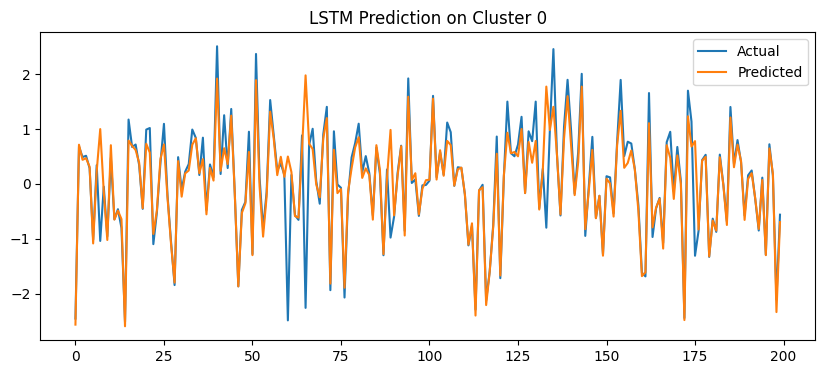

In [16]:
# === 6. Predict and visualize ===
y_pred = model.predict(X_test)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(y_test[:200], label='Actual')
plt.plot(y_pred[:200], label='Predicted')
plt.legend()
plt.title(f"LSTM Prediction on Cluster {selected_cluster}")
plt.show()


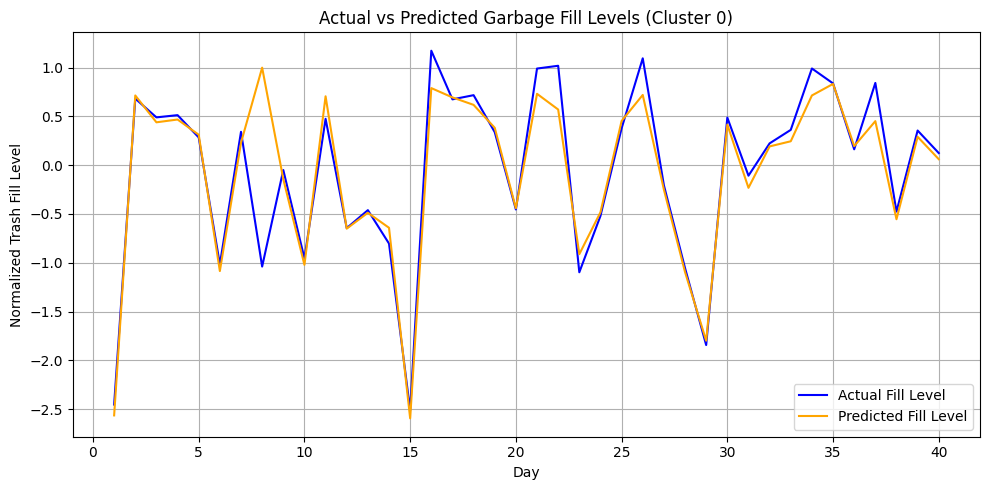

In [17]:
import matplotlib.pyplot as plt

# Pick the first 40 points from test set
days = np.arange(1, 41)
actual_vals = y_test[:40]
predicted_vals = y_pred[:40].flatten()

plt.figure(figsize=(10, 5))
plt.plot(days, actual_vals, label='Actual Fill Level', color='blue')
plt.plot(days, predicted_vals, label='Predicted Fill Level', color='orange')
plt.xlabel("Day")
plt.ylabel("Normalized Trash Fill Level")
plt.title(f"Actual vs Predicted Garbage Fill Levels (Cluster {selected_cluster})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()